<a href="https://colab.research.google.com/github/codecakes/ud_students_data_analysis/blob/master/ud_students_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
%config IPCompleter.greedy=True


In [21]:
%cd ~/Documents/projects/ud_data_analysis/

/home/codecakes/Documents/projects/ud_data_analysis


In [64]:
daily_engagement_sample_df = pd.read_csv('daily_engagement.csv', infer_datetime_format=True, engine='c')
daily_engagement_sample_df.head(2)

,acct,utc_date,num_courses_visited,total_minutes_visited,lessons_completed,projects_completed
0,0,2015-01-09,1.0,11.679374,0.0,0.0
1,0,2015-01-10,2.0,37.284887,0.0,0.0


In [0]:

columns = ['utc_date', 'acct', 'registration_date', 'subscription_start',
       'course_key', 'sibling_key', 'course_title', 'has_visited',
       'total_minutes_visited', 'lessons_completed', 'projects_completed',
       'account_key']
engagements = pd.read_csv(
    'daily_engagement_full.csv', infer_datetime_format=True, engine='c', 
    usecols=columns)


In [73]:
engagements.astype({k: str for k in ['acct', 'course_key', 'sibling_key', 'course_title', 'account_key']})
engagements.astype({k: 'datetime64[ns]' for k in ['utc_date', 'registration_date', 'subscription_start']})
engagements.head(10)

,utc_date,acct,registration_date,subscription_start,course_key,sibling_key,course_title,has_visited,total_minutes_visited,lessons_completed,projects_completed,account_key
0,2014-11-05,448,2014-08-05,2014-11-05,ud359-nd,ud359,Intro to Data Science,0.0,0.0,0.0,0.0,2257038596
1,2014-11-05,448,2014-08-05,2014-11-05,ud120-nd,ud120,Intro to Machine Learning,0.0,0.0,0.0,0.0,2257038596
2,2014-11-05,448,2014-08-05,2014-11-05,ud651-nd,ud651,Data Analysis with R,0.0,0.0,0.0,0.0,2257038596
3,2014-11-05,448,2014-08-05,2014-11-05,ud507-nd,ud507,Data Visualization and D3.js,0.0,0.0,0.0,0.0,2257038596
4,2014-11-05,448,2014-08-05,2014-11-05,ud651,ud651,Data Analysis with R,0.0,0.0,0.0,0.0,2257038596
5,2014-11-05,448,2014-08-05,2014-11-05,ud804-nd,ud804,JavaScript Basics,0.0,0.0,0.0,0.0,2257038596
6,2014-11-05,448,2014-08-05,2014-11-05,ud032-nd,ud032,Data Wrangling with MongoDB,0.0,0.0,0.0,0.0,2257038596
7,2014-11-05,448,2014-08-05,2014-11-05,ud304-nd,ud304,Intro to HTML and CSS,0.0,0.0,0.0,0.0,2257038596
8,2014-11-05,448,2014-08-05,2014-11-05,ud120,ud120,Intro to Machine Learning,0.0,0.0,0.0,0.0,2257038596
9,2014-11-05,448,2014-08-05,2014-11-05,ud359,ud359,Intro to Data Science,0.0,0.0,0.0,0.0,2257038596


In [38]:
engagements.dtypes

utc_date                  object
acct                       int64
registration_date         object
subscription_start        object
course_key                object
sibling_key               object
course_title              object
has_visited              float64
total_minutes_visited    float64
lessons_completed        float64
projects_completed       float64
account_key               object
dtype: object

In [0]:
columns=['account_key', 'status', 'join_date', 'cancel_date', 'days_to_cancel',
       'is_udacity', 'is_canceled']
enrollments_df = pd.read_csv(
'enrollments.csv', infer_datetime_format=True, engine='c', usecols=columns)

In [62]:
enrollments_df.astype({
    'cancel_date': 'datetime64[ns]', 
    'account_key': str,
    'status': str,
    'days_to_cancel': float,
    'is_udacity': bool,
    'is_canceled': bool,
    })

,account_key,status,join_date,cancel_date,days_to_cancel,is_udacity,is_canceled
0,448,canceled,2014-11-10,2015-01-14,65.0,True,True
1,448,canceled,2014-11-05,2014-11-10,5.0,True,True
2,448,canceled,2015-01-27,2015-01-27,0.0,True,True
3,448,canceled,2014-11-10,2014-11-10,0.0,True,True
4,448,current,2015-03-10,NaT,NaN,True,False
...,...,...,...,...,...,...,...
1635,1176,current,2015-08-12,NaT,NaN,False,False
1636,1110,current,2015-08-13,NaT,NaN,False,False
1637,1116,canceled,2015-08-15,2015-08-18,3.0,False,True
1638,874,current,2015-08-22,NaT,NaN,False,False


In [0]:
project_submissions = pd.read_csv(
    'project_submissions.csv', infer_datetime_format=True, engine='c')

In [60]:
project_submissions.astype({
    'creation_date': 'datetime64[ns]',
    'completion_date': 'datetime64[ns]',
    'assigned_rating': str,
    'account_key': str,
    'lesson_key': str,
    })

,creation_date,completion_date,assigned_rating,account_key,lesson_key,processing_state
0,2015-01-14,2015-01-16,UNGRADED,256,3176718735,EVALUATED
1,2015-01-10,2015-01-13,INCOMPLETE,256,3176718735,EVALUATED
2,2015-01-20,2015-01-20,PASSED,256,3176718735,EVALUATED
3,2015-03-10,2015-03-13,PASSED,434,3176718735,EVALUATED
4,2015-02-17,2015-03-03,INCOMPLETE,434,3176718735,EVALUATED
...,...,...,...,...,...,...
3637,2015-01-13,2015-01-22,PASSED,243,3176718735,EVALUATED
3638,2015-07-07,2015-07-07,INCOMPLETE,771,3176718735,EVALUATED
3639,2015-08-16,2015-08-16,PASSED,2,3176718735,EVALUATED
3640,2015-03-03,2015-03-11,PASSED,623,3176718735,EVALUATED


How many students enrolled?

How many students passed/failed/didnt finish?

when did students frequently join?

is there a correlation between students joining/completing projects vs pass status?





### Get Total Unique Engagements, Enrollments, Submissions

In [0]:
uniq_student_engagement=engagements.drop_duplicates(subset=['acct'])
uniq_student_enrollment = enrollments_df.drop_duplicates(subset=['account_key'])
uniq_student_submission = project_submissions.drop_duplicates(subset=['account_key'])


In [111]:
uniq_student_engagement.size

14844

In [112]:
uniq_student_enrollment.size

9114

In [113]:
uniq_student_submission.size

4458

In [121]:
uniq_student_enrollment.tail(5)

,account_key,status,join_date,cancel_date,days_to_cancel,is_udacity,is_canceled
1635,1176,current,2015-08-12,NaN,NaN,False,False
1636,1110,current,2015-08-13,NaN,NaN,False,False
1637,1116,canceled,2015-08-15,2015-08-18,3.0,False,True
1638,874,current,2015-08-22,NaN,NaN,False,False
1639,686,current,2015-08-23,NaN,NaN,False,False


In [123]:
uniq_student_engagement.tail(5)

,utc_date,acct,registration_date,subscription_start,course_key,sibling_key,course_title,has_visited,total_minutes_visited,lessons_completed,projects_completed,account_key
2308859,2015-08-23,686,2012-10-20,2015-08-23,ud032-nd,ud032,Data Wrangling with MongoDB,0.0,0.0,0.0,0.0,u28015558
2308878,2015-08-23,1067,2012-08-30,2015-08-22,ud120-nd,ud120,Intro to Machine Learning,0.0,0.0,0.0,0.0,u20522597
2308973,2015-08-23,874,2015-08-05,2015-08-22,ud651-nd,ud651,Data Analysis with R,0.0,0.0,0.0,0.0,4804719296
2309068,2015-08-23,754,2015-01-22,2015-08-21,ud359-nd,ud359,Intro to Data Science,0.0,0.0,0.0,0.0,3567109205
2309163,2015-08-23,854,2012-10-12,2015-08-23,ud359-nd,ud359,Intro to Data Science,0.0,0.0,0.0,0.0,u26334020


In [0]:
uniq_enrolled_accounts = uniq_student_enrollment['account_key']
uniq_engagement_accounts = uniq_student_engagement['acct']

In [133]:
uniq_enrolled_accounts.size

1302

In [129]:
uniq_engagement_accounts.size

1237

In [130]:
uniq_engagement_accounts.head(5)

0        448
4858      44
9641     258
13657    366
16059    587
Name: acct, dtype: int64

In [134]:
uniq_enrolled_accounts.head(5)

0      448
9      700
10     429
12      60
15    1300
Name: account_key, dtype: int64

### Get total Unique Accounts Enrolled but Not Engaged 

In [148]:
enrolled_not_engaged_accounts = uniq_enrolled_accounts[~uniq_enrolled_accounts.isin(uniq_engagement_accounts)]
enrolled_not_engaged_accounts

65      1219
75       871
193     1218
216      654
220      964
        ... 
1501    1079
1543    1063
1563    1270
1608    1291
1613    1241
Name: account_key, Length: 65, dtype: int64

In [150]:
uniq_student_enrollment[uniq_student_enrollment['account_key'].isin(enrolled_not_engaged_accounts)]

,account_key,status,join_date,cancel_date,days_to_cancel,is_udacity,is_canceled
65,1219,canceled,2014-11-12,2014-11-12,0.0,False,True
75,871,canceled,2014-11-13,2014-11-13,0.0,False,True
193,1218,canceled,2014-11-15,2014-11-15,0.0,False,True
216,654,canceled,2014-12-04,2014-12-04,0.0,False,True
220,964,canceled,2014-12-04,2014-12-04,0.0,False,True
...,...,...,...,...,...,...,...
1501,1079,canceled,2015-02-09,2015-02-09,0.0,False,True
1543,1063,canceled,2015-07-14,2015-07-14,0.0,False,True
1563,1270,canceled,2015-07-20,2015-07-20,0.0,False,True
1608,1291,canceled,2015-06-03,2015-06-03,0.0,False,True


## **Lets look at the project submissions grouped by accounts.**

In [184]:
project_submissions.head(5)

,creation_date,completion_date,assigned_rating,account_key,lesson_key,processing_state
0,2015-01-14,2015-01-16,UNGRADED,256,3176718735,EVALUATED
1,2015-01-10,2015-01-13,INCOMPLETE,256,3176718735,EVALUATED
2,2015-01-20,2015-01-20,PASSED,256,3176718735,EVALUATED
3,2015-03-10,2015-03-13,PASSED,434,3176718735,EVALUATED
4,2015-02-17,2015-03-03,INCOMPLETE,434,3176718735,EVALUATED


In [0]:
submissions_groupby_account = project_submissions.groupby(by='account_key', squeeze=True)

### Project submissions in descending order

In [283]:
submissions_groupby_account.size().sort_values(ascending=False)

account_key
569    27
281    20
557    17
427    17
426    17
       ..
928     1
470     1
601     1
378     1
701     1
Length: 743, dtype: int64

### Segregate Submitted Projects by their submission status(Assigned Rating)

In [0]:
project_grouped = project_submissions.groupby(by=['account_key', 'assigned_rating'])

In [285]:
project_grouped_size=project_grouped.size()
project_grouped_size

account_key  assigned_rating
0            INCOMPLETE         5
             PASSED             2
1            INCOMPLETE         1
             PASSED             2
2            PASSED             1
                               ..
1263         PASSED             1
1274         PASSED             1
1279         PASSED             1
1292         INCOMPLETE         1
1298         INCOMPLETE         2
Length: 1408, dtype: int64

In [286]:
project_grouped_size.sort_values(ascending=False)

account_key  assigned_rating
569          INCOMPLETE         20
281          INCOMPLETE         16
557          INCOMPLETE         13
641          INCOMPLETE         12
426          INCOMPLETE         11
                                ..
497          PASSED              1
209          DISTINCTION         1
208          INCOMPLETE          1
503          INCOMPLETE          1
353          PASSED              1
Length: 1408, dtype: int64

In [0]:
project_grouped_sample = project_grouped.size().unstack(fill_value=0).head(10)

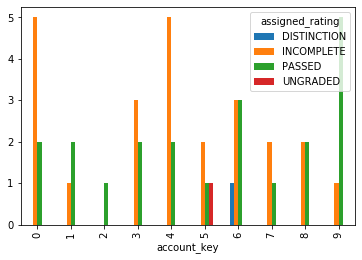

In [262]:
project_grouped_sample.plot.bar()

In [265]:
grouped_ratings = project_grouped.size().unstack(fill_value=0)
grouped_ratings

assigned_rating,DISTINCTION,INCOMPLETE,PASSED,UNGRADED
account_key,,,,
0,0,5,2,0
1,0,1,2,0
2,0,0,1,0
3,0,3,2,0
4,0,5,2,0
...,...,...,...,...
1263,0,0,1,0
1274,0,0,1,0
1279,0,0,1,0


In [295]:
grouped_ratings.sort_values(['DISTINCTION'], ascending=False)

assigned_rating,DISTINCTION,INCOMPLETE,PASSED,UNGRADED
account_key,,,,
553,2,3,3,2
45,2,2,1,0
627,2,3,0,0
156,2,3,0,0
328,1,6,6,0
...,...,...,...,...
254,0,5,3,2
255,0,2,2,0
256,0,1,1,1


In [272]:
grouped_ratings.sort_values(['DISTINCTION', 'PASSED'], ascending=False)

assigned_rating,DISTINCTION,INCOMPLETE,PASSED,UNGRADED
account_key,,,,
553,2,3,3,2
45,2,2,1,0
156,2,3,0,0
627,2,3,0,0
328,1,6,6,0
...,...,...,...,...
1206,0,1,0,0
1215,0,3,0,0
1247,0,2,0,0


In [273]:
grouped_ratings.sort_values(['PASSED'], ascending=False)

assigned_rating,DISTINCTION,INCOMPLETE,PASSED,UNGRADED
account_key,,,,
317,0,6,8,0
85,0,6,8,0
569,0,20,7,0
125,0,8,7,0
316,0,4,7,0
...,...,...,...,...
1013,0,1,0,0
1033,0,3,0,0
1048,0,1,0,0


In [275]:
grouped_ratings.sort_values(['INCOMPLETE'], ascending=False)

assigned_rating,DISTINCTION,INCOMPLETE,PASSED,UNGRADED
account_key,,,,
569,0,20,7,0
281,0,16,4,0
557,0,13,4,0
641,0,12,5,0
427,0,11,5,1
...,...,...,...,...
65,0,0,1,0
64,0,0,1,0
447,0,0,1,0


In [276]:
grouped_ratings.sort_values(['UNGRADED'], ascending=False)

assigned_rating,DISTINCTION,INCOMPLETE,PASSED,UNGRADED
account_key,,,,
634,0,3,2,2
461,0,2,4,2
755,0,0,0,2
553,2,3,3,2
643,0,5,2,2
...,...,...,...,...
263,0,5,4,0
264,0,0,1,0
265,0,0,1,0


## Lets look at the nature of Cumulative Submission Status 

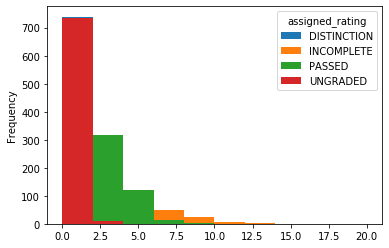

In [289]:
grouped_ratings.plot.hist(by='assigned_rating')

In [294]:
grouped_ratings.agg(np.sum)

assigned_rating
DISTINCTION      36
INCOMPLETE     1912
PASSED         1630
UNGRADED         58
dtype: int64

# Observations

*   There are **more Incomplete submissions** than **Passed**
*   There are **more Passed submissions** than **Ungraded**
*   The Ungraded submissions per account is not more than 2.
*   There are not more than 20 incomplete submissions per account.
*   At best an account has passed 8 submissions.
*   Someone doing very well **with Distinction** has **also had 
incomplete and ungraded submissions**. 


